A replication for certain plots/results in R can be found here:
https://christophj.github.io/replicating/r/replicating-goyal-welch-2008/

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# use notebook working directory; data is in the parent directory
notebook_dir = Path.cwd().parent
file_path_monthly = notebook_dir / "data" / "GW2024_Complete_Monthly.csv"
file_path_yearly = notebook_dir / "data" / "GW24_Complete_Annual.csv"
data_monthly = pd.read_csv(file_path_monthly)
data_annual = pd.read_csv(file_path_yearly)
data_monthly['yyyymm'] = pd.to_datetime(data_monthly['yyyymm'], format='%Y%m')
data_monthly.rename(columns={'yyyymm': 'date'}, inplace=True)


## Replicating annual log equity premium

In [3]:
# annual excess return
annual_05 = data_annual.loc[data_annual['yyyy'] <= 2005].copy()
annual_05.loc[:, 'annual_log_equity_premium'] = np.log1p(annual_05['ret']) - np.log1p(annual_05['Rfree'])
annual_05['annual_log_equity_premium'].describe()

count    80.000000
mean      0.059409
std       0.196934
min      -0.617069
25%      -0.053176
50%       0.087990
75%       0.197363
max       0.423189
Name: annual_log_equity_premium, dtype: float64

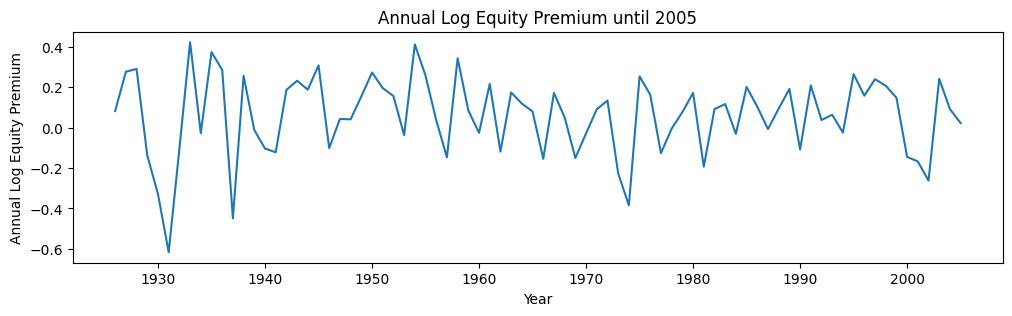

In [4]:
# plot premium over time
plt.figure(figsize=(12, 3))
plt.plot(annual_05['yyyy'], annual_05['annual_log_equity_premium'])
plt.title("Annual Log Equity Premium until 2005")
plt.xlabel("Year")
plt.ylabel("Annual Log Equity Premium")
plt.show()

These equity premia are close to the ones from Goyal/Welch (2008, p.1457). They differ slightly because I use the updated data from 2024 and some of the values for Rfree and ret were updated (even the values for 1926 were updated, which seems a bit far back). Plot is nearly identical to Figure 1 from [GW2003](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=300750).

In [5]:
# excess returns for the full sample
annual = data_annual.copy()
annual.loc[:, 'annual_log_equity_premium'] = np.log1p(annual['ret']) - np.log1p(annual['Rfree'])
annual['annual_log_equity_premium'].describe()

count    99.000000
mean      0.064786
std       0.193641
min      -0.617069
25%      -0.029718
50%       0.094247
75%       0.193825
max       0.423189
Name: annual_log_equity_premium, dtype: float64

In [6]:
annual.set_index('yyyy', inplace=True)

## Replicating plots from Goyal/Welch (2008)
They make annual predictions, first 20 years are for not used for OOS Forecast.

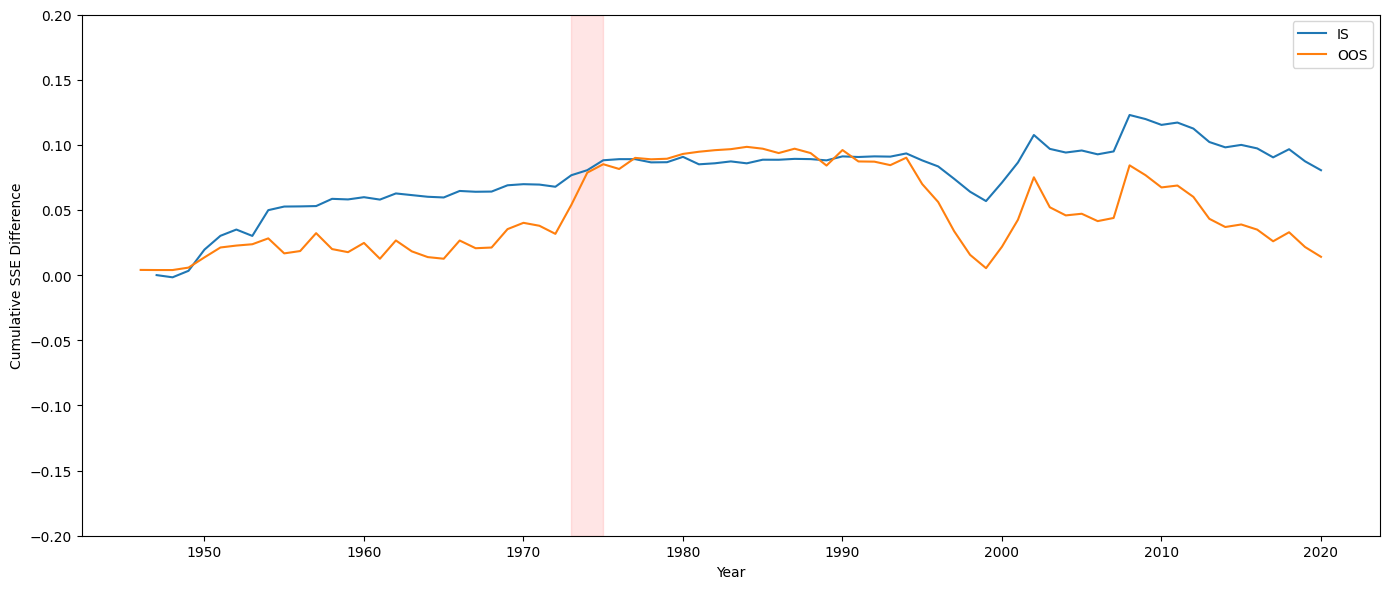

In [7]:
from helper import get_statistics as help_get_stat
house_stat = help_get_stat(annual, indep='d/p', dep='annual_log_equity_premium', start=1925, end=2020)

For interpretation see GW2008: "These figures plot the IS and OOS performance of annual predictive regressions. Specifically,
these are the cumulative squared prediction errors of the NULL minus the cumulative squared prediction
error of the ALTERNATIVE. The ALTERNATIVE is a model that relies on predictive variables noted
in each graph. The NULL is the prevailing equity premium mean for the OOS graph, and the full-period
equity premium mean for the IS graph. The IS prediction relative performance is dotted (and usually
above), the OOS prediction relative perfomance is solid. An increase in a line indicates better performance
of the named model; a decrease in a line indicates better performance of the NULL. The blue band is the
equivalent of 95% two-sided levels, based on MSE-T critical values from McCracken (2004). (MSE-T is
the Diebold and Mariano (1995)
t-statistic modified by Harvey, Leybourne, and Newbold (1998)). The
right axis shifts the zero point to 1965. The Oil Shock is marked by a red vertical line."

In [8]:
def linear_regression(X_in, y_in, start, end):
    # regression of lzrt on log_equity_premium, code:mnclx
    X = X_in.dropna()
    X = X.loc[start:end]
    y = y_in.loc[X.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

In [9]:
accrul = linear_regression(annual[['house']], annual['annual_log_equity_premium'], '1936', '2021')
print(accrul.summary())

                                OLS Regression Results                               
Dep. Variable:     annual_log_equity_premium   R-squared:                       0.010
Model:                                   OLS   Adj. R-squared:                 -0.002
Method:                        Least Squares   F-statistic:                    0.8258
Date:                       Wed, 29 Oct 2025   Prob (F-statistic):              0.366
Time:                               17:36:25   Log-Likelihood:                 29.715
No. Observations:                         86   AIC:                            -55.43
Df Residuals:                             84   BIC:                            -50.52
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

# Monthly Data

In [10]:
print(data_monthly.head())
print(data_monthly.shape)

        date  price   d12  e12  ret  retx  AAA  BAA  lty  ltr  ...  ygap  \
0 1871-01-01   4.44  0.26  0.4  NaN   NaN  NaN  NaN  NaN  NaN  ...   NaN   
1 1871-02-01   4.50  0.26  0.4  NaN   NaN  NaN  NaN  NaN  NaN  ...   NaN   
2 1871-03-01   4.61  0.26  0.4  NaN   NaN  NaN  NaN  NaN  NaN  ...   NaN   
3 1871-04-01   4.74  0.26  0.4  NaN   NaN  NaN  NaN  NaN  NaN  ...   NaN   
4 1871-05-01   4.86  0.26  0.4  NaN   NaN  NaN  NaN  NaN  NaN  ...   NaN   

   rdsp  rsvix  gpce  gip  tchi  house  avgcor  shtint  disag  
0   NaN    NaN   NaN  NaN   NaN    NaN     NaN     NaN    NaN  
1   NaN    NaN   NaN  NaN   NaN    NaN     NaN     NaN    NaN  
2   NaN    NaN   NaN  NaN   NaN    NaN     NaN     NaN    NaN  
3   NaN    NaN   NaN  NaN   NaN    NaN     NaN     NaN    NaN  
4   NaN    NaN   NaN  NaN   NaN    NaN     NaN     NaN    NaN  

[5 rows x 57 columns]
(1848, 57)


In [11]:
# show columns with only nan values
nan_columns = data_monthly.columns[data_monthly.isna().all()].tolist()
print("Columns with only NaN values:", nan_columns)
# delete these columns
data_monthly.drop(columns=nan_columns, inplace=True)
print("Shape after dropping NaN columns:", data_monthly.shape)

Columns with only NaN values: ['eqis', 'cay', 'i/k', 'pce', 'govik', 'skew', 'crdstd', 'accrul', 'cfacc', 'gpce', 'gip', 'house']
Shape after dropping NaN columns: (1848, 45)


In [12]:
data_monthly.describe()

,date,price,d12,e12,ret,retx,AAA,BAA,lty,ltr,...,fbm,dtoy,dtoat,ygap,rdsp,rsvix,tchi,avgcor,shtint,disag
count,1848,1848.000000,1848.000000,1848.000000,1188.000000,1188.000000,1272.000000,1272.000000,1272.000000,1188.000000,...,1182.000000,1188.000000,1188.000000,861.000000,1182.000000,332.000000,8.880000e+02,1186.000000,6.240000e+02,517.000000
mean,1947-12-16 15:31:56.883116928,417.394778,8.104819,19.302541,0.009627,0.006558,0.056364,0.068024,0.049082,0.004575,...,0.243091,0.920119,0.791234,-2.909605,0.039218,0.041891,-1.114865e-07,0.284313,-8.012821e-09,3.623891
min,1871-01-01 00:00:00,2.730000,0.180000,0.160000,-0.287461,-0.291524,0.021400,0.029400,0.006200,-0.112400,...,-1.363875,0.275924,0.112391,-4.868848,0.014326,0.008223,-2.681880e+00,0.034739,-2.236186e+00,2.255945
25%,1909-06-23 12:00:00,8.010000,0.425600,0.580000,-0.016829,-0.019196,0.036400,0.048300,0.028400,-0.007525,...,0.160684,0.893603,0.707003,-3.142419,0.024712,0.019380,-8.699770e-01,0.196972,-6.824493e-01,3.021161
50%,1947-12-16 12:00:00,18.770000,0.965000,1.626650,0.013161,0.009591,0.049200,0.061950,0.041700,0.003000,...,0.226123,0.956713,0.894181,-2.927001,0.030976,0.031140,8.188800e-01,0.267202,7.586200e-02,3.411661
75%,1986-06-08 12:00:00,236.815000,8.110825,15.237500,0.038927,0.035935,0.072625,0.083400,0.063550,0.015825,...,0.306147,0.987381,0.969171,-2.665644,0.042464,0.050972,1.055849e+00,0.348263,6.342877e-01,4.189495
max,2024-12-01 00:00:00,6032.380000,74.832300,210.170000,0.414312,0.412291,0.154900,0.171800,0.148200,0.152300,...,0.842323,1.000000,1.000000,-2.018659,0.420465,0.283216,1.055849e+00,0.707789,2.674143e+00,6.401161
std,NaN,919.392864,14.963458,38.540201,0.053881,0.053956,0.026483,0.028113,0.026835,0.024452,...,0.220396,0.103153,0.233620,0.400927,0.028576,0.036663,1.424530e+00,0.120318,1.000000e+00,0.730094


For a description of each of the variables, see data/GW2024_info.md

In [13]:
# plot every variable over time in a grid
# import matplotlib.pyplot as plt
# num_vars = data_monthly.shape[1] - 1  # exclude date column
# num_cols = 4
# num_rows = (num_vars + num_cols - 1) // num_cols
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
# for i, column in enumerate(data_monthly.columns[1:]):  # exclude date column
#     ax = axes[i // num_cols, i % num_cols]
#     ax.plot(data_monthly['date'], data_monthly[column])
#     ax.set_title(column)
#     ax.set_xlabel('Date')
#     ax.set_ylabel(column)
# plt.tight_layout()
# plt.show()

The variable to be forecasted is: "log equity premiums using CRSP’s definition of the S&P 500 including
dividends net of the (Ken French posted) Treasury return in nonoverlapping
periods at their native frequencies" (GWZ24). In the data this should be Rfree (for riskfree return) and ret (return w/ dividends). A Rfree of 0.0049 means 0.49% return over a month with riskfree rate (annualized this would be > 5%).

In [14]:
data_monthly['log_equity_premium'] = np.log1p(data_monthly['ret']) - np.log1p(data_monthly['Rfree'])

In [15]:
data_monthly["log_equity_premium"].describe()

count    1188.000000
mean        0.005466
std         0.053750
min        -0.339221
25%        -0.019978
50%         0.010113
75%         0.035221
max         0.345644
Name: log_equity_premium, dtype: float64

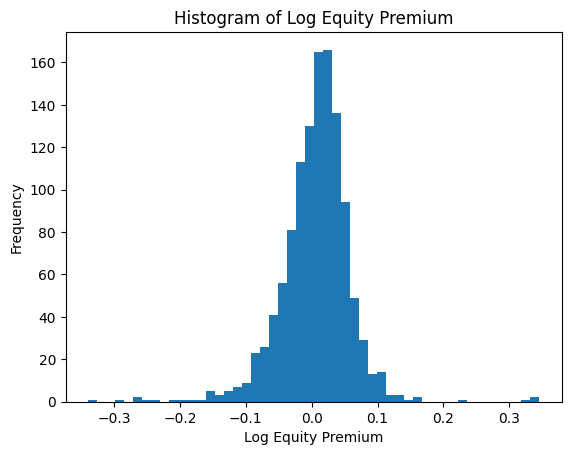

In [16]:
# plot histogram of excess returns
plt.hist(data_monthly["log_equity_premium"].dropna(), bins=50)
plt.title("Histogram of Log Equity Premium")
plt.xlabel("Log Equity Premium")
plt.ylabel("Frequency")
plt.show()

In [17]:
data_monthly.set_index('date', inplace=True)

In [18]:
model = linear_regression(data_monthly[['tail']], data_monthly['log_equity_premium'], '1963-01', '2010-12')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_equity_premium   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.225
Date:                Wed, 29 Oct 2025   Prob (F-statistic):              0.136
Time:                        17:36:25   Log-Likelihood:                 985.55
No. Observations:                 576   AIC:                            -1967.
Df Residuals:                     574   BIC:                            -1958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.017     -1.279      0.2